In [98]:
# !pip uninstall tensorflow tensorflow-tensorboard tensorflow-estimator
!pip install gdown
!pip install tensorflow-gpu

In [99]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [100]:
df = pd.read_csv(
  "/home/jovyan/work/training_data/sw_training_data.csv", 
  parse_dates=['read_date'], 
  index_col="read_date"
)

In [101]:
df = df.drop(['bl_meter1','bl_meter2','bl_meter3','bl_ahd3','mean_temp3','bl_meter4','bl_ahd4','mean_temp4','sl_meter','rf_meter'
             ],axis=1)

In [102]:
df.shape


(5297, 6)

In [103]:
df.shape[0]



5297

In [104]:
df.shape[1]

6

In [105]:
df.head()

,sl_read1,bl_ahd1,mean_temp1,bl_ahd2,mean_temp2,rf_read1
read_date,,,,,,
2005-12-02,0.295,253.271,19.800,251.641,21.400,19.8
2005-12-03,0.303,253.277,19.825,251.644,21.350,21.4
2005-12-04,0.307,253.278,19.800,251.639,21.375,0.0
2005-12-05,0.303,253.275,19.824,251.636,21.375,0.0
2005-12-06,0.304,253.273,19.801,251.638,21.400,0.0


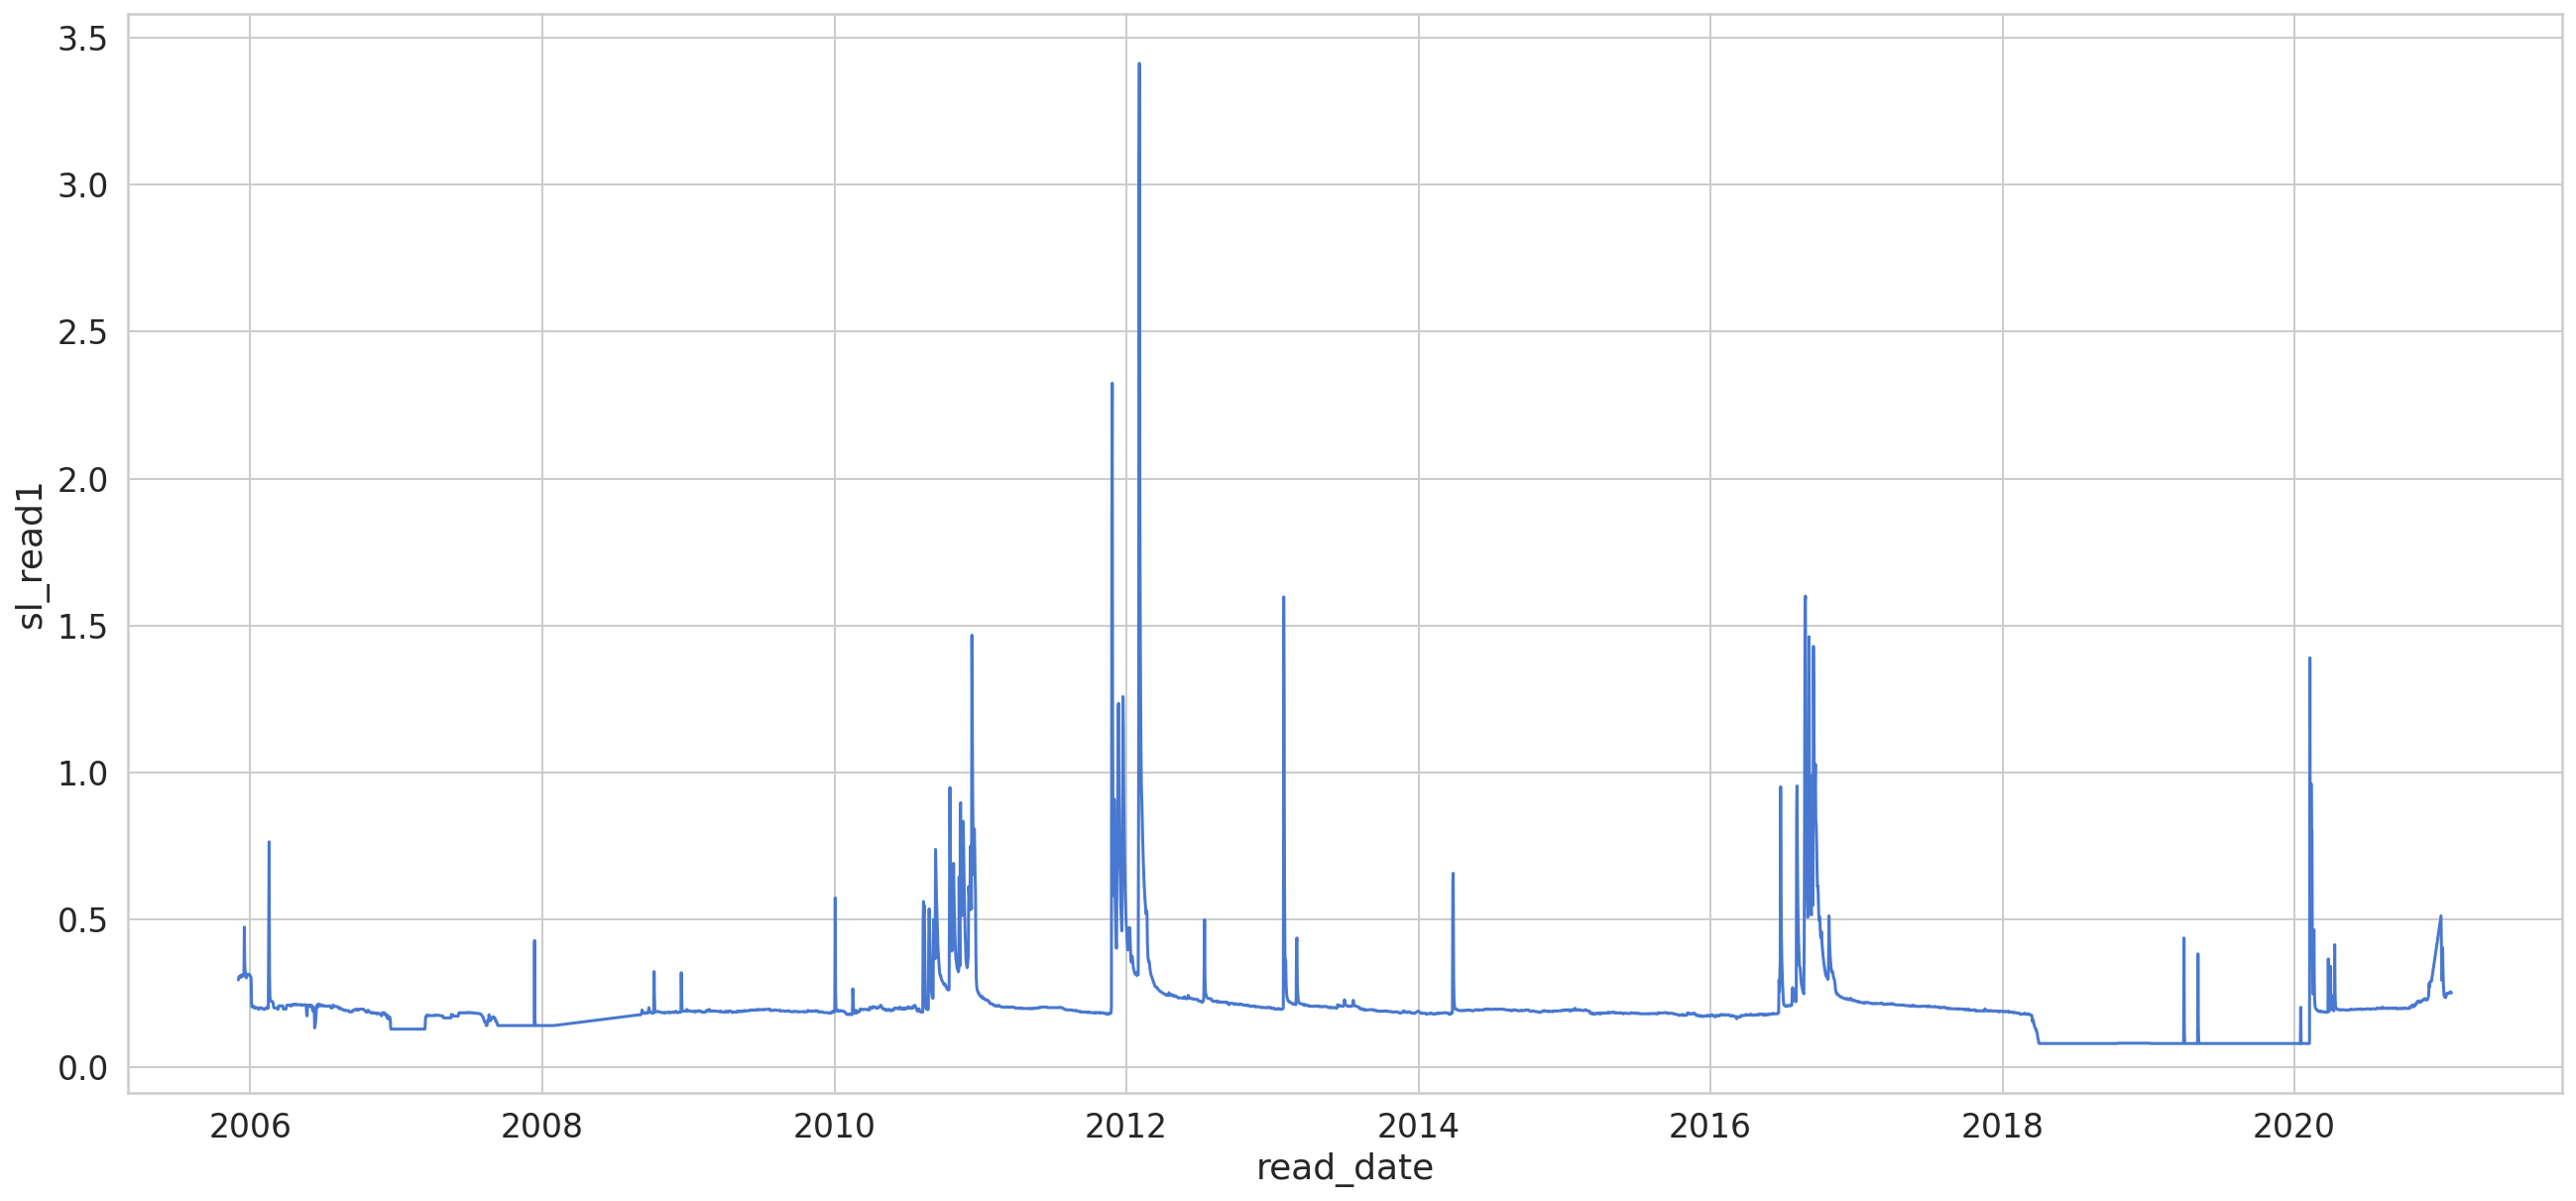

In [106]:
sns.lineplot(x=df.index, y="sl_read1", data=df);

In [107]:
train_size = int(len(df) * 0.75)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
#df_test=test.copy()
print(len(train), len(test))


3972 1325


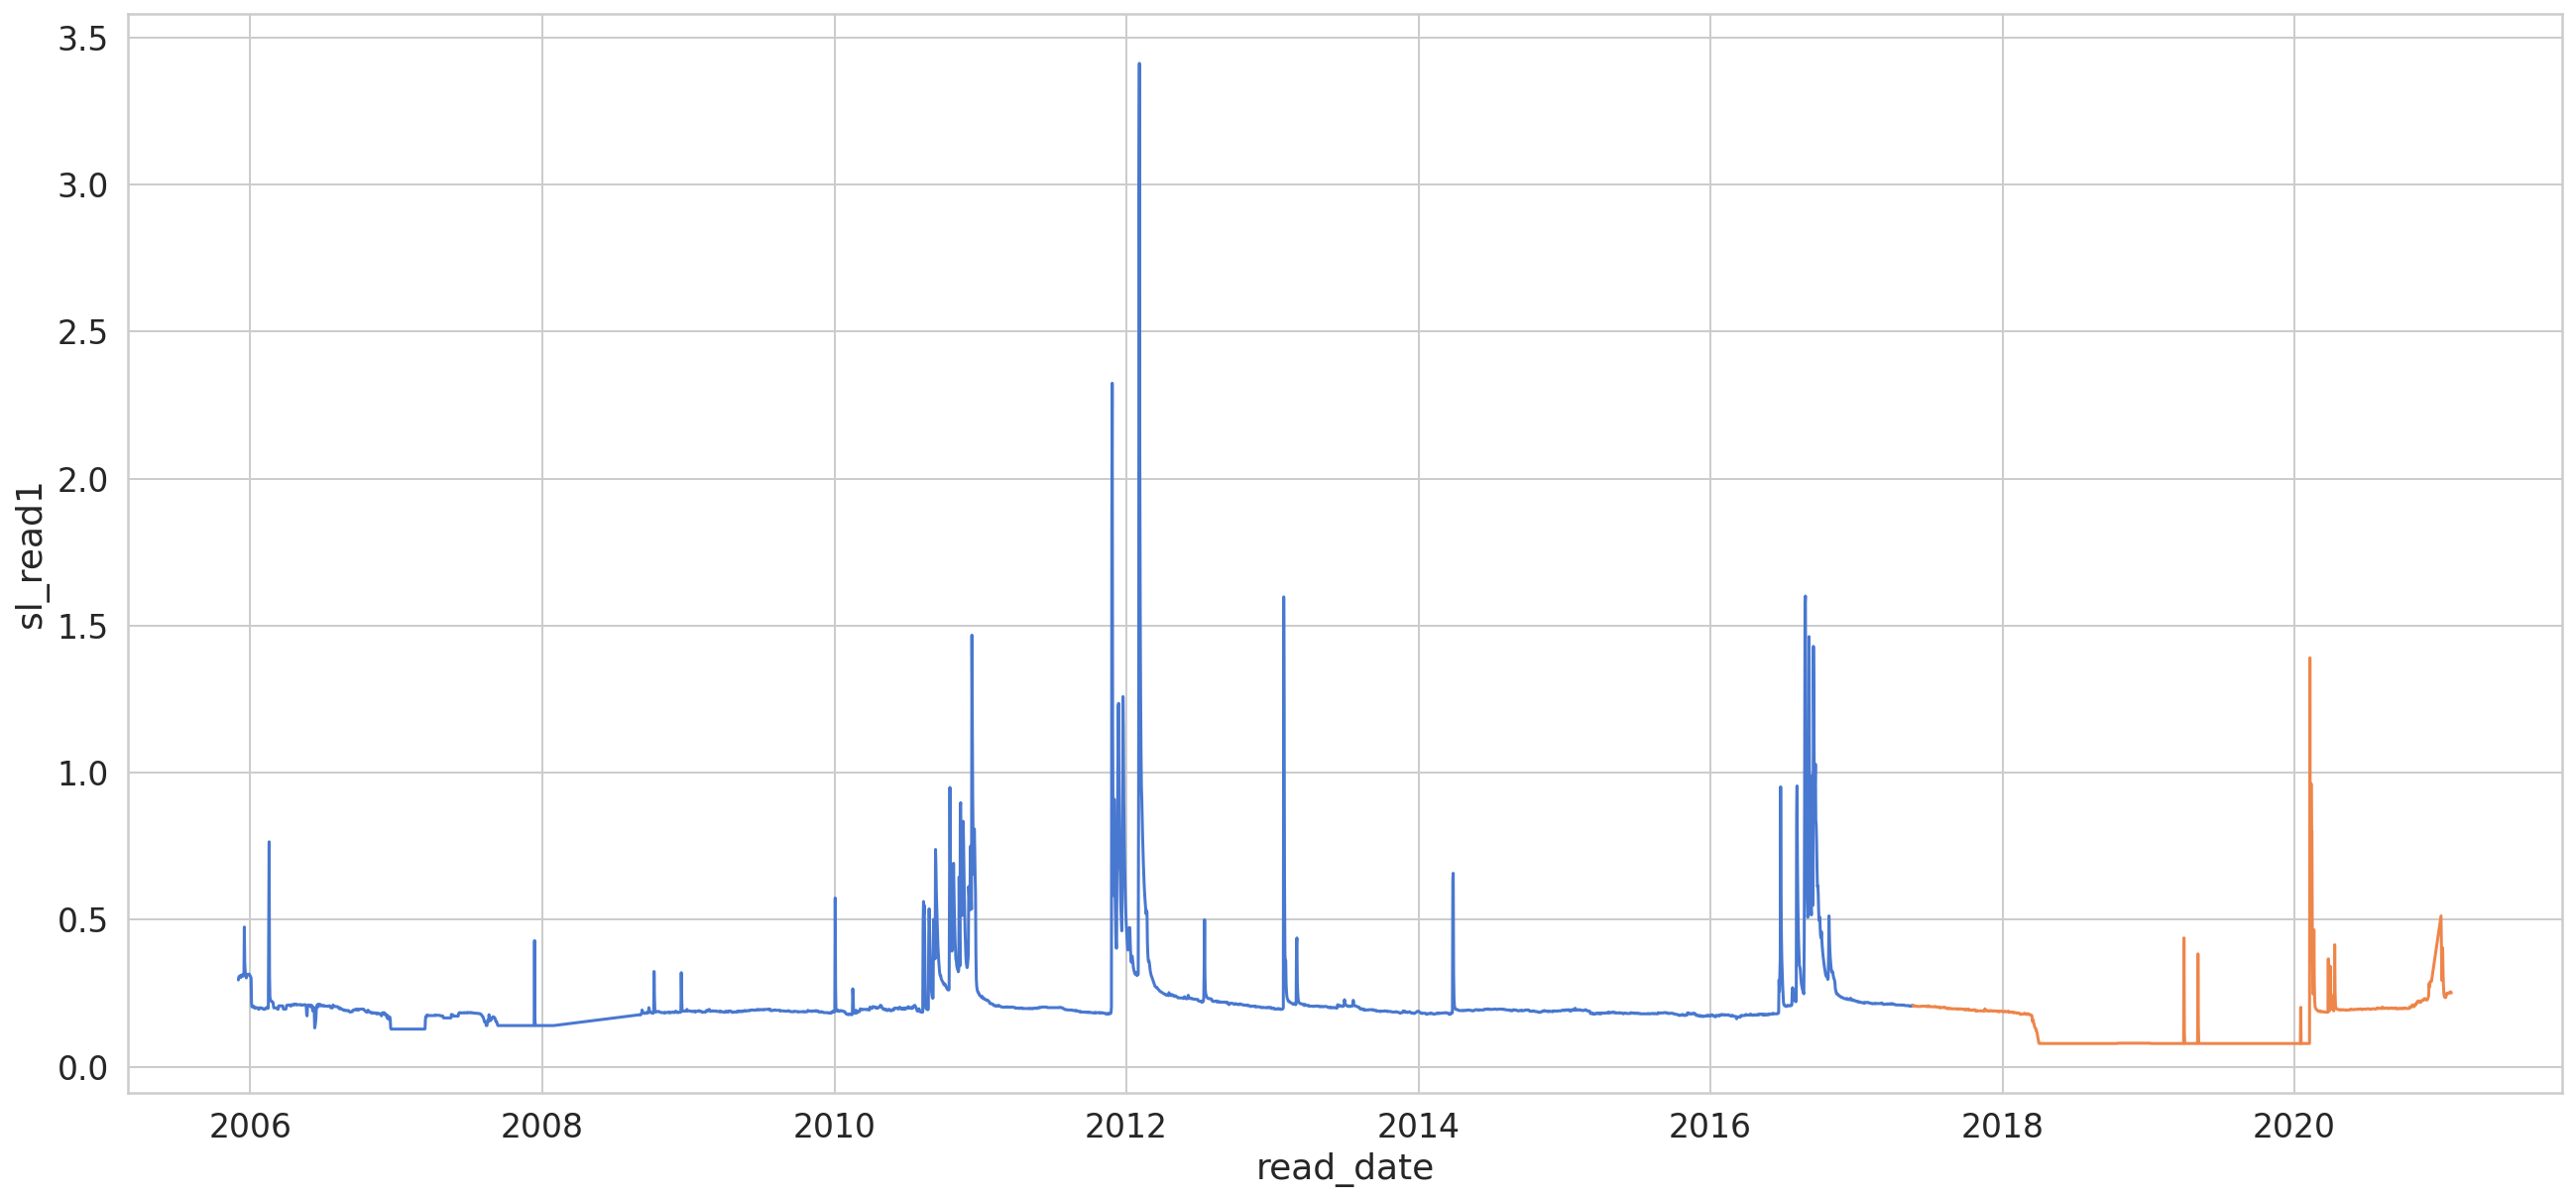

In [108]:
sns.lineplot(x=train.index, y="sl_read1", data=train);
sns.lineplot(x=test.index, y="sl_read1", data=test);

# Skip

In [13]:
from sklearn.preprocessing import RobustScaler


rf_columns = ['mean_temp1','mean_temp2','rf_read1']
sl_columns = ['bl_ahd1', 'bl_ahd2','sl_read1']

rf_transformer = RobustScaler()
sl_transformer = RobustScaler()

rf_transformer = rf_transformer.fit(train[rf_columns].to_numpy())
sl_transformer = sl_transformer.fit(train[sl_columns].to_numpy())

train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
train.loc[:, sl_columns] = sl_transformer.transform(train[sl_columns].to_numpy())

test.loc[:, rf_columns] = rf_transformer.transform(test[rf_columns].to_numpy())
test.loc[:, sl_columns] = sl_transformer.transform(test[sl_columns].to_numpy())



# f_transformer = f_transformer.fit(train[f_columns].to_numpy())
# sl_transformer = sl_transformer.fit(train[y_columns].to_numpy())
# 
# 
# 
# train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
# train.loc[:, y_columns] = sl_transformer.transform(train[y_columns].to_numpy())
# 
# test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
# test.loc[:, y_columns] = sl_transformer.transform(train[y_columns].to_numpy())


/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-13-8be39b4a597e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:, rf_columns] = rf_transformer.transform(train[rf_columns].to_numpy())
/opt/conda/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc

# Skip

In [109]:
def create_dataset(X, y1, y2, y3, time_steps=1):
    
    Xs, y1s, y2s, y3s = [], [], [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        y1s.append(y1.iloc[i + time_steps])
        y2s.append(y2.iloc[i + time_steps])
        y3s.append(y3.iloc[i + time_steps])
        
    
    return np.array(Xs), np.array(y1s), np.array(y2s), np.array(y3s) 

In [110]:
time_steps = 10

train_sl = ['train.bl_ahd1', 'train.bl_ahd2','train.sl_read1']
test_sl = ['test.bl_ahd1', 'test.bl_ahd2','test.sl_read1']
# reshape to [samples, time_steps, n_features]

# X_train, Y_train = create_dataset(train, train.sl_read1, time_steps)
# X_test, Y_test = create_dataset(test,test.sl_read1, time_steps)

X_train, y1_train, y2_train, y3_train = create_dataset(train, train.bl_ahd1,train.bl_ahd2,train.sl_read1,time_steps)
X_test, y1_test, y2_test, y3_test = create_dataset(test,test.bl_ahd1,test.bl_ahd2,test.sl_read1, time_steps)

Y_train = np.concatenate((y1_train, y3_train, y3_train))
Y_test = np.concatenate((y1_test, y3_test, y3_test))
print(X_train.shape, Y_train.shape, y1_train.shape, y2_train.shape, y3_train.shape)
print(X_test.shape, Y_test.shape, y1_test.shape, y2_test.shape, y3_test.shape)
# print(X_train)
# print(Y_train)

(3962, 10, 6) (11886,) (3962,) (3962,) (3962,)
(1315, 10, 6) (3945,) (1315,) (1315,) (1315,)


In [65]:
def create_dataset(X, Y, time_steps=1):
    
    Xs, Ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        
        z = Y.iloc[i:(i + time_steps)].values
        Ys.append(z)
        
    return np.array(Xs, dtype=float), np.array(Ys, dtype=object)  #x = np.asarray(x).astype('float32')

In [73]:
time_steps = 10

#train_fld = [train.bl_ahd1, train.bl_ahd2,train.sl_read1]
#test_fld = [test.bl_ahd1, test.bl_ahd2,test.sl_read1]

train_sl = ['train.bl_ahd1', 'train.bl_ahd2','train.sl_read1']
test_sl = ['test.bl_ahd1', 'test.bl_ahd2','test.sl_read1']

train_sl = pd.DataFrame(train_fld)
test_sl = pd.DataFrame(test_fld)

# reshape to [samples, time_steps, n_features]

# X_train, Y_train = create_dataset(train, train.sl_read1, time_steps)
# X_test, Y_test = create_dataset(test,test.sl_read1, time_steps)

X_train, Y_train = create_dataset(train, train_sl,time_steps)
X_test, Y_test = create_dataset(test,test_sl, time_steps)

#Y_train = np.asarray(Y_train)

print(X_train.shape, X_train.dtype, Y_train.shape, Y_train.dtype)
print(Y_train)
print(X_test.shape, X_test.dtype, Y_test.shape,  Y_test.dtype)
# print(X_train)
# print(Y_train)

(3962, 10, 6) float64 (3962,) object
[array([[2.53271e+02, 2.53277e+02, 2.53278e+02, ..., 2.53019e+02,
        2.53038e+02, 2.53034e+02],
       [2.51641e+02, 2.51644e+02, 2.51639e+02, ..., 2.51656e+02,
        2.51684e+02, 2.51684e+02],
       [2.95000e-01, 3.03000e-01, 3.07000e-01, ..., 2.06000e-01,
        2.09000e-01, 2.09000e-01]])
 array([[2.51641e+02, 2.51644e+02, 2.51639e+02, ..., 2.51656e+02,
        2.51684e+02, 2.51684e+02],
       [2.95000e-01, 3.03000e-01, 3.07000e-01, ..., 2.06000e-01,
        2.09000e-01, 2.09000e-01]])
 array([[0.295, 0.303, 0.307, ..., 0.206, 0.209, 0.209]]) ...
 array([], shape=(0, 3972), dtype=float64)
 array([], shape=(0, 3972), dtype=float64)
 array([], shape=(0, 3972), dtype=float64)]
(1315, 10, 6) float64 (1315,) object


In [111]:
history = model.fit(
    X_train, Y_train,
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
112/112 [==============================] - 2s 13ms/step - loss: 127.4932 - val_loss: 0.4286
Epoch 2/30
112/112 [==============================] - 1s 11ms/step - loss: 133.7790 - val_loss: 0.1382
Epoch 3/30
112/112 [==============================] - 1s 12ms/step - loss: 124.7298 - val_loss: 0.0953
Epoch 4/30
112/112 [==============================] - 1s 13ms/step - loss: 134.9774 - val_loss: 0.3897
Epoch 5/30
112/112 [==============================] - 1s 13ms/step - loss: 130.1162 - val_loss: 0.5774
Epoch 6/30
112/112 [==============================] - 1s 11ms/step - loss: 125.9838 - val_loss: 0.8441
Epoch 7/30
112/112 [==============================] - 1s 12ms/step - loss: 131.7706 - val_loss: 0.3565
Epoch 8/30
112/112 [==============================] - 1s 11ms/step - loss: 130.2774 - val_loss: 0.2843
Epoch 9/30
112/112 [==============================] - 1s 11ms/step - loss: 127.5569 - val_loss: 1.0600
Epoch 10/30
112/112 [==============================] - 1s 11ms/step - los

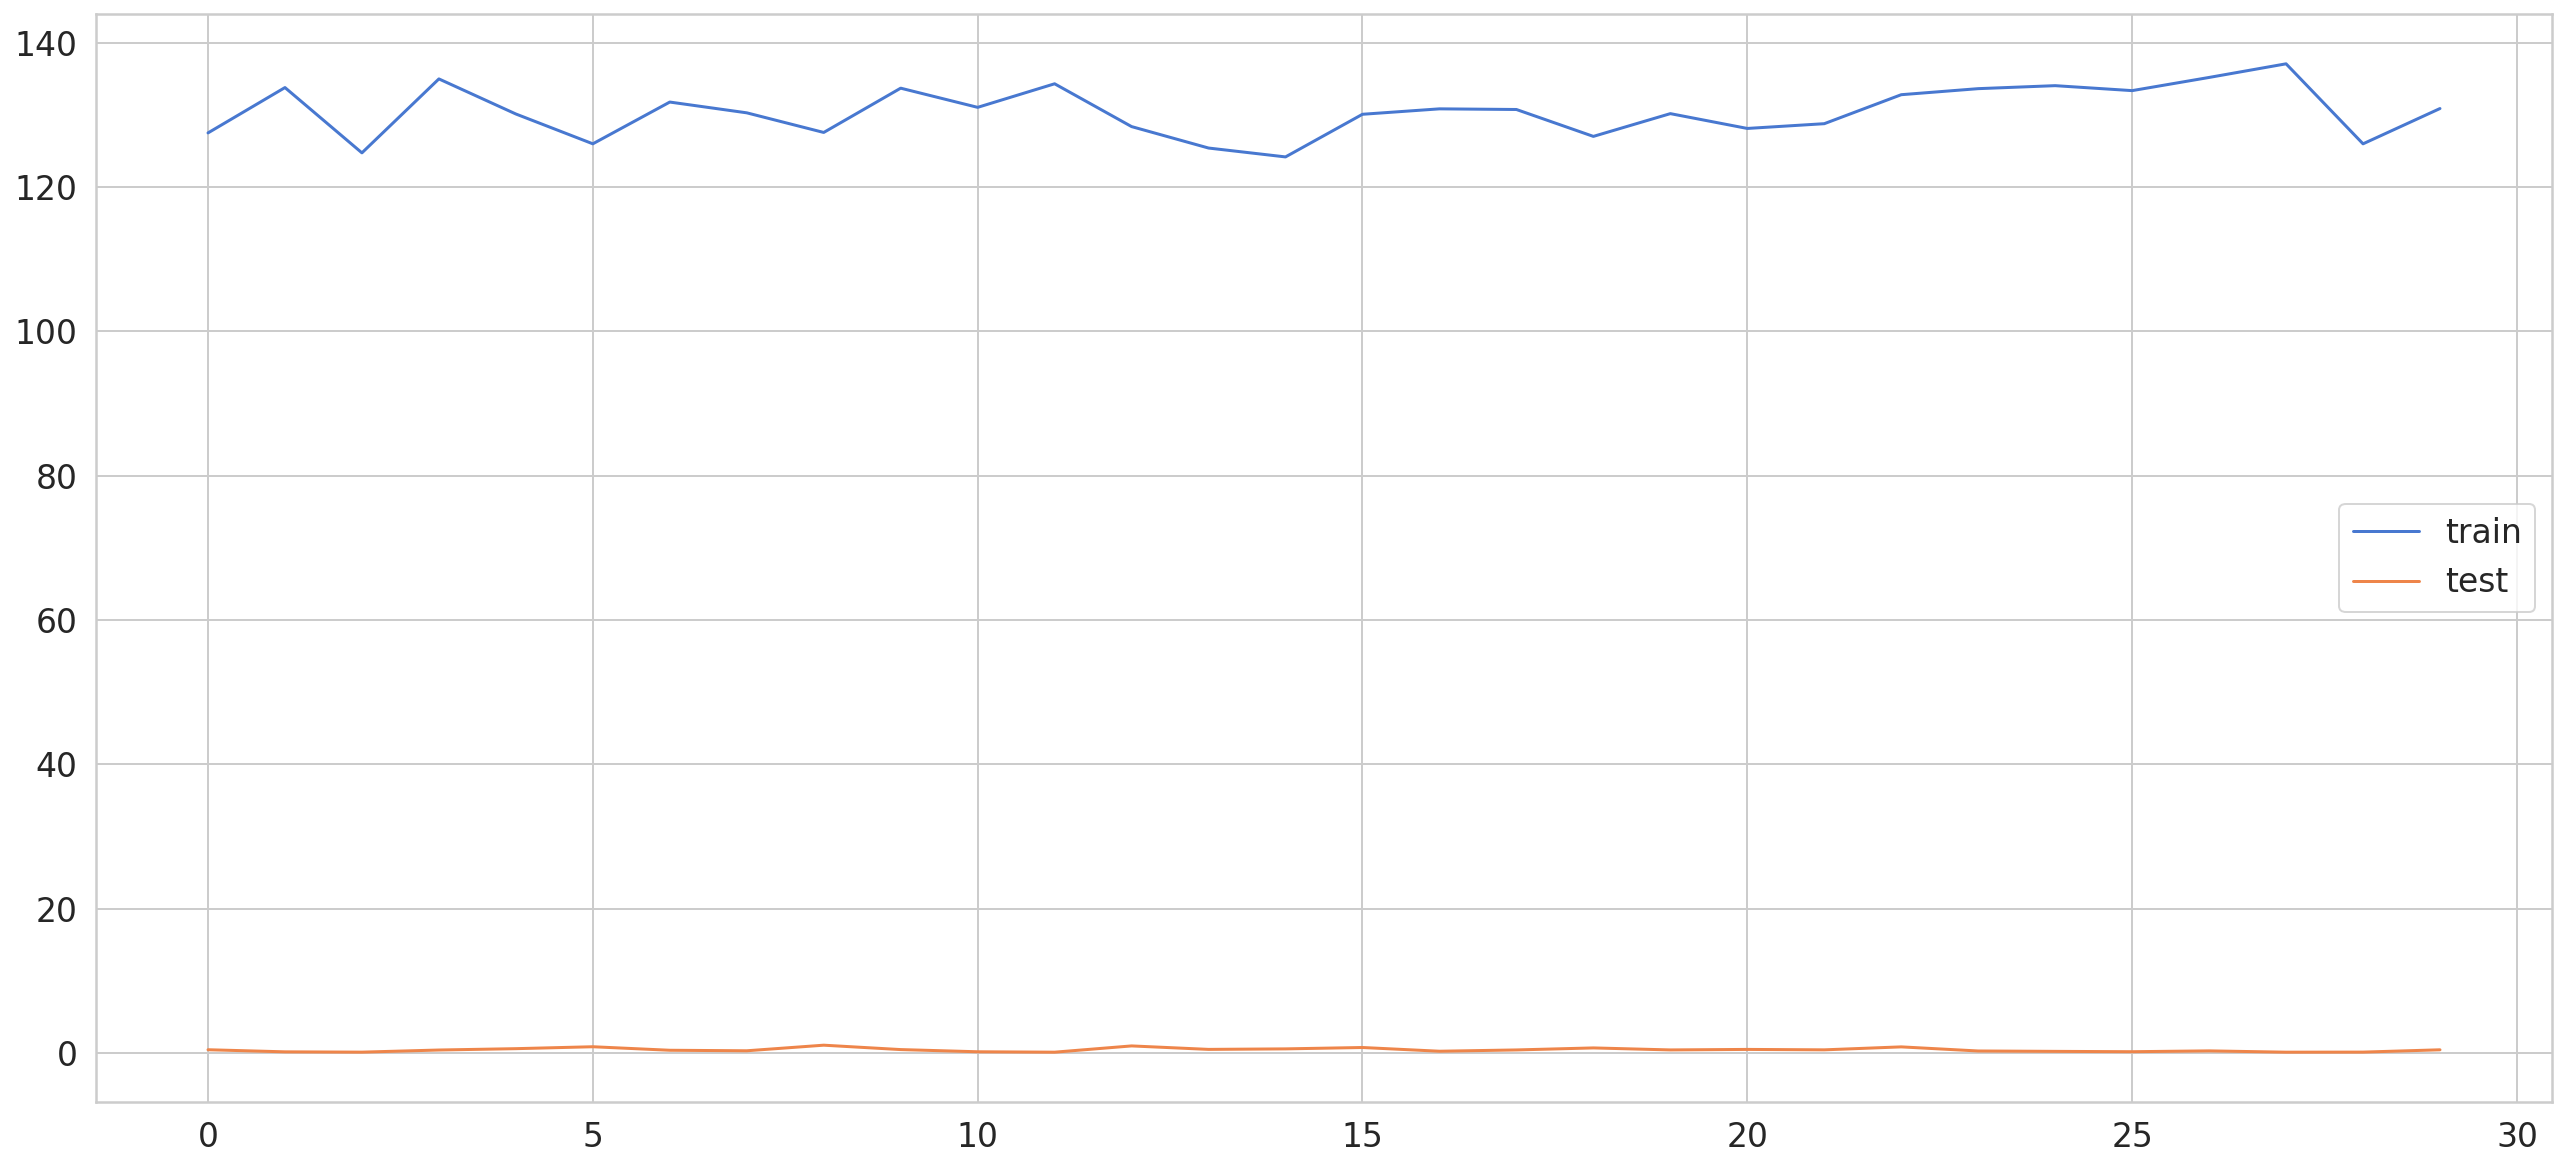

In [112]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [113]:
Y_pred = model.predict(X_test)

Skip

In [26]:
Y_train_inv = sl_transformer.inverse_transform(sl_columns.reshape(1, -1))
Y_test_inv = sl_transformer.inverse_transform(sl_columns.reshape(1, -1))
Y_pred_inv = sl_transformer.inverse_transform(Y_pred)

NameError: name 'sl_transformer' is not defined

ValueError: x and y must have same first dimension, but have shapes (3945,) and (1315, 1)

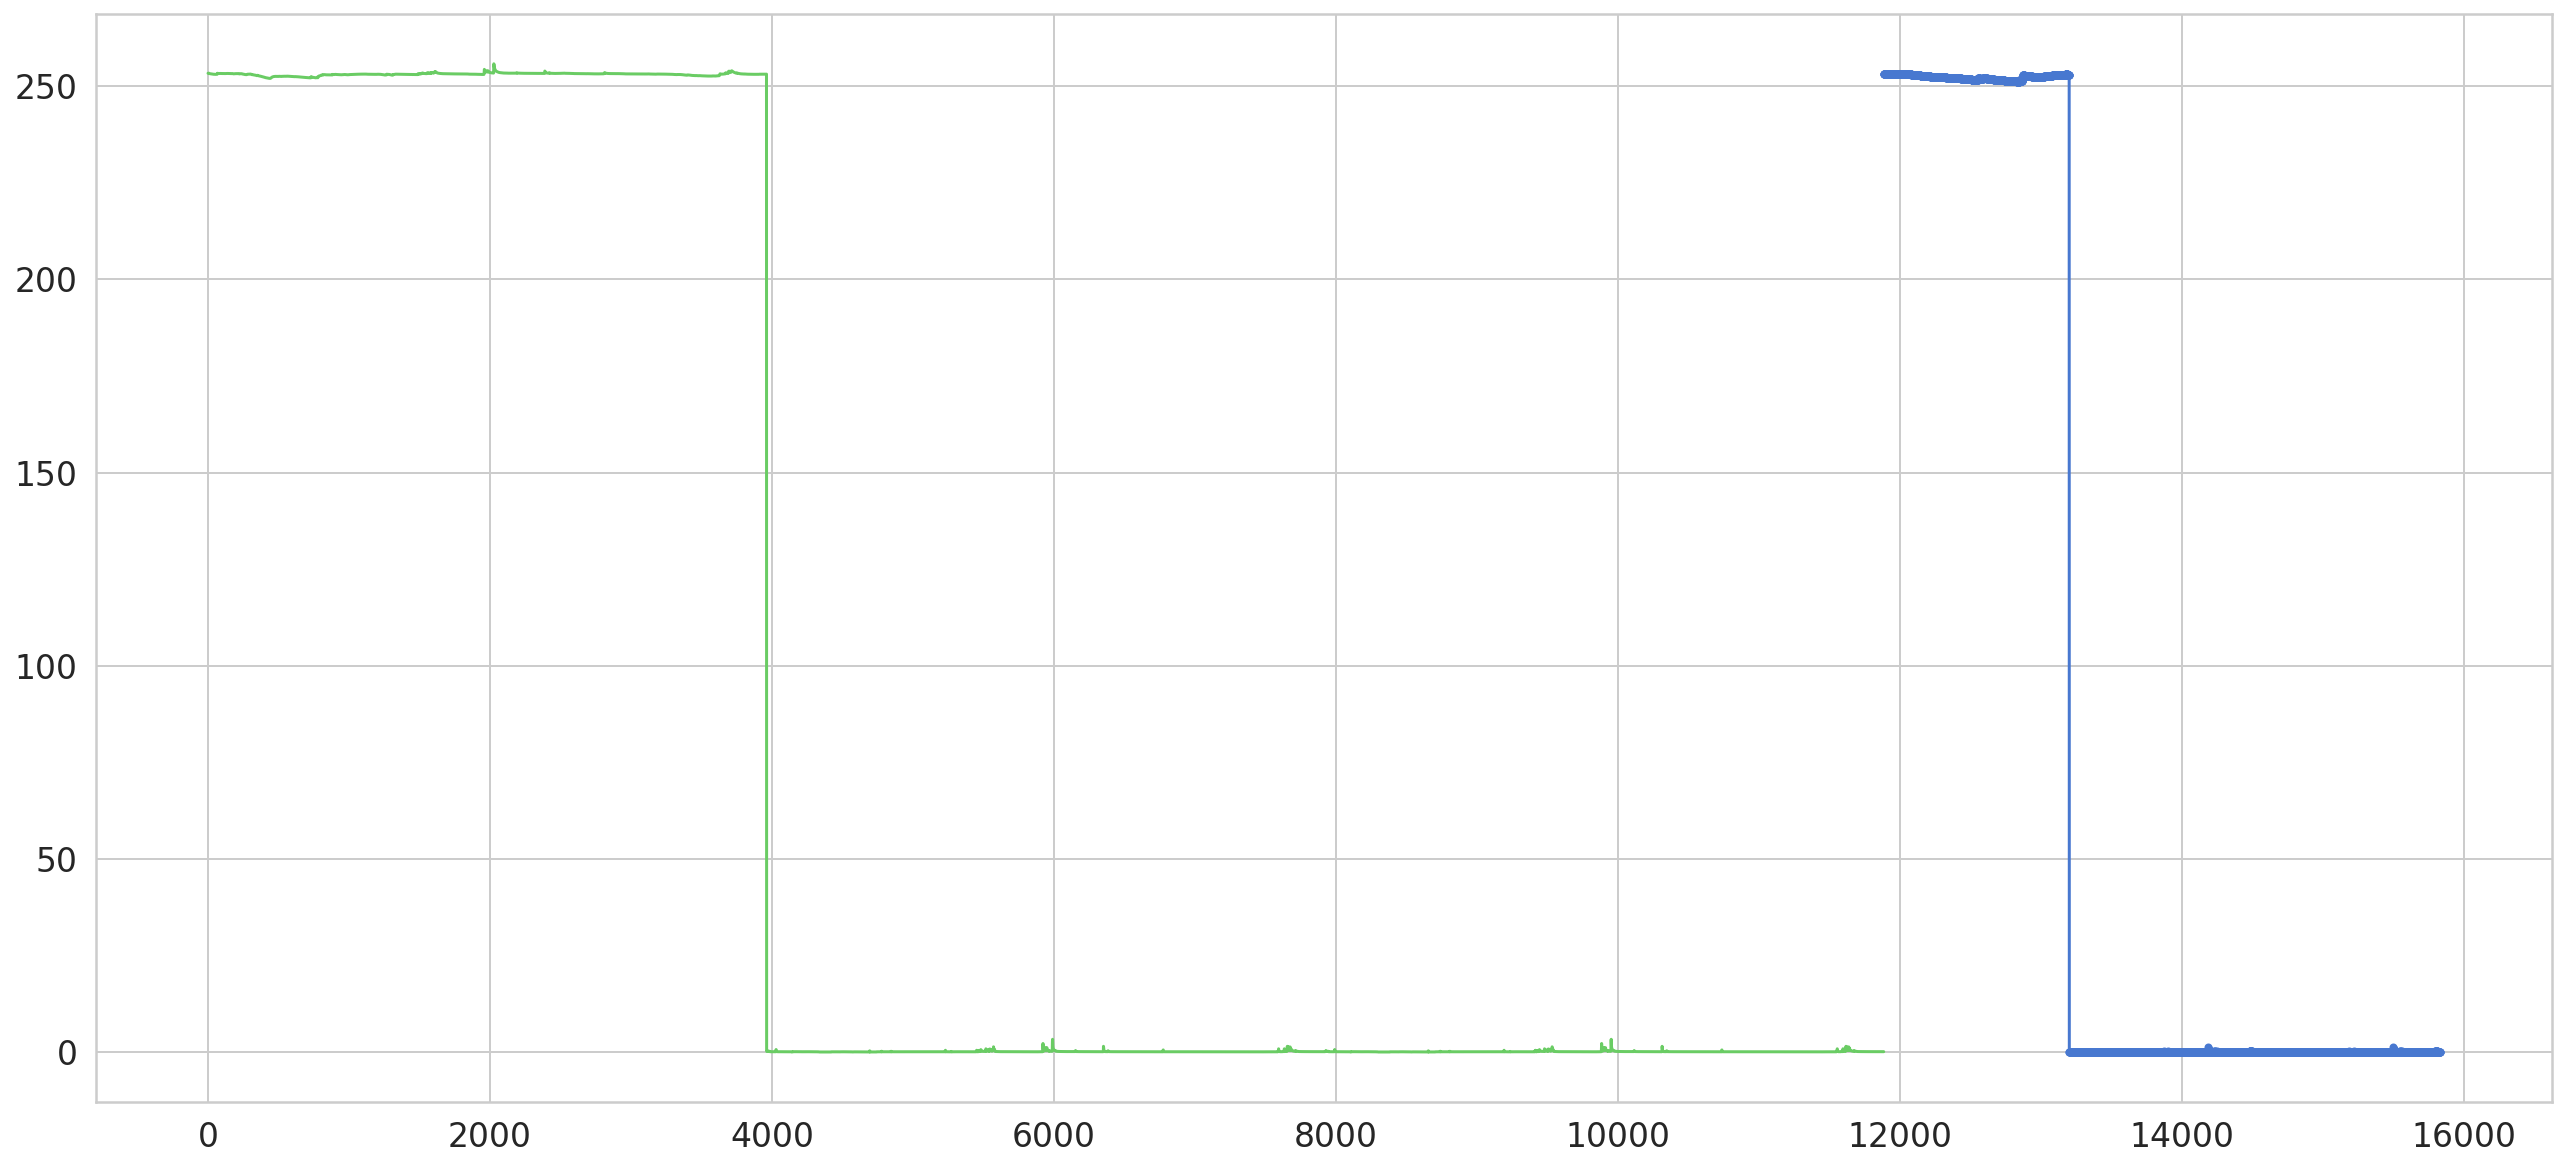

In [114]:
plt.plot(np.arange(0, len(Y_train)), Y_train, 'g', label="history")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_test, marker='.', label="true")
plt.plot(np.arange(len(Y_train), len(Y_train) + len(Y_test)), Y_pred, 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

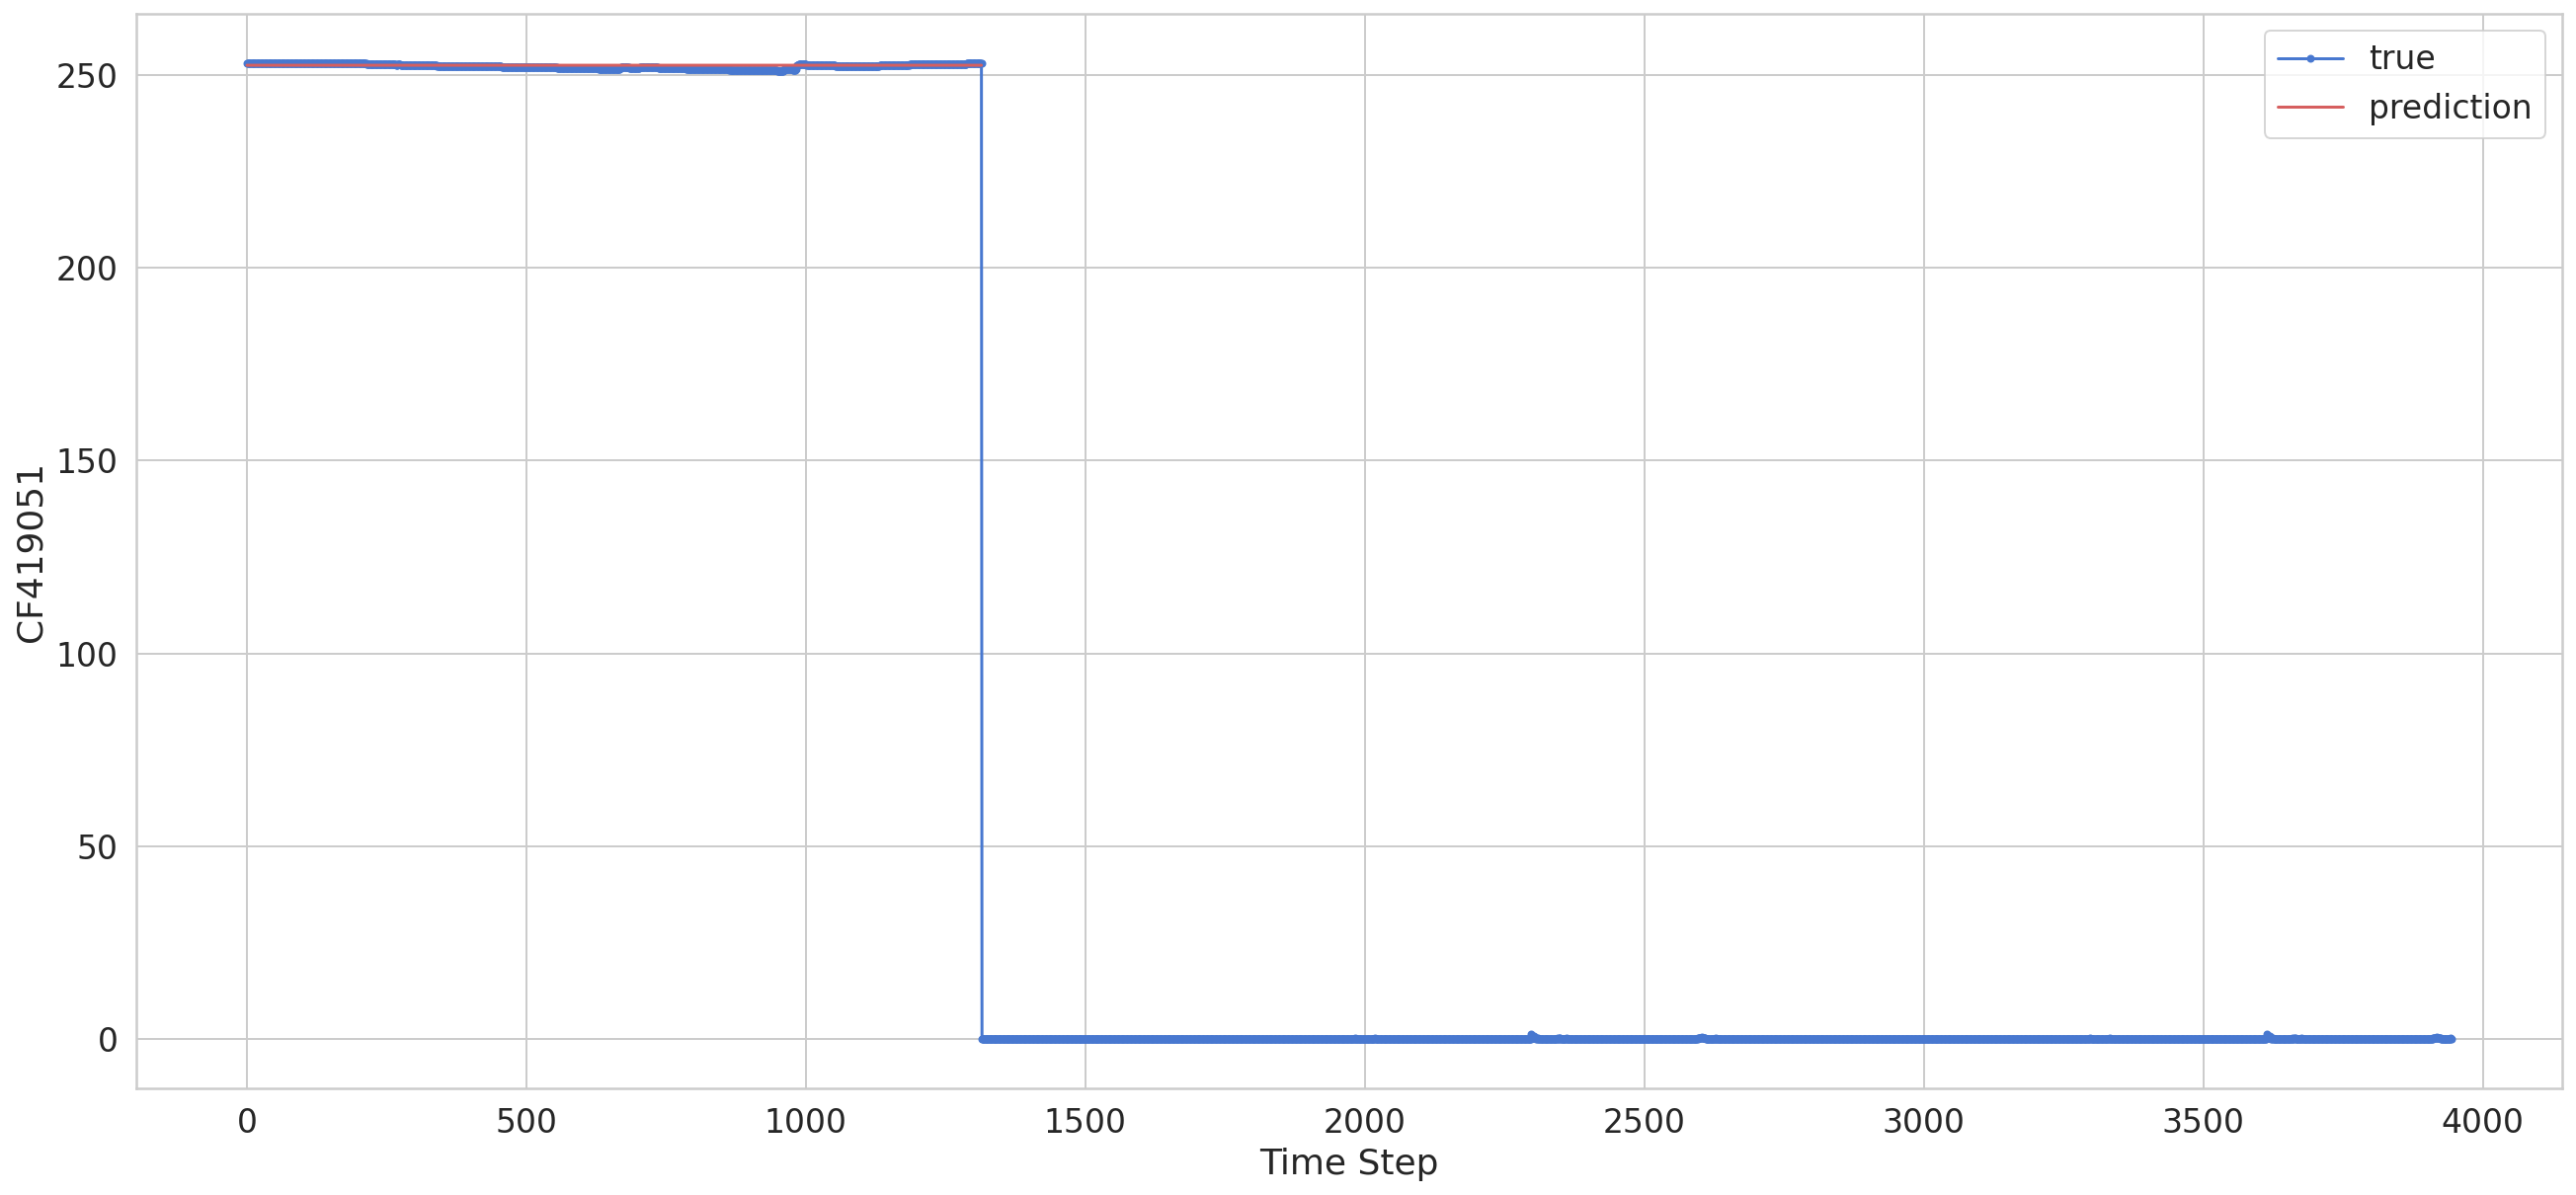

In [96]:
plt.plot(Y_test.flatten(), marker='.', label="true")
plt.plot(Y_pred.flatten(), 'r', label="prediction")
plt.ylabel('CF419051')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [97]:
print(Y_pred)
#y_pred_inv.to_csv('/home/jovyan/work/predictions/sw_pred.csv', index=False)

[[252.49832]
 [252.49832]
 [252.49832]
 ...
 [252.49832]
 [252.49832]
 [252.49832]]


In [358]:
print(y_pred.dtype)


df_test.cols['sl_pred'] = 0.0
df_test.insert(loc=len(df_test.columns),column='sl_pred', value=

print(df_test)

df_y_pred = pd.DataFrame(y_pred_inv)
#df_y_pred.insert(loc=0, column='read_date', value='2020-01-01')
#df_test = test_inv.copy()

for i in range(len(df_test)):
  
    if (i == time_steps):
        j = 0
        df_test.iloc[i,6] == df_y_pred.iloc[j,0]
        print('i: ',i, 'date: ', df_test.index[i], df_test.iloc[i,6])
    
        j = j + 1

    
print(df_y_pred)

#
sda
df_y_pred = pd.DataFrame(y_pred_inv)  #,index=None,dtype=float
df_y_pred.insert(loc=0, column='read_date', value='2021-01-01')

#df['Date'] = pd.to_datetime(df['Date'])
df_y_pred.shape
#df_y_pred.insert(loc=0, column='read_date', value=player_vals)

df_y_pred

#df_test.to_csv('/home/jovyan/work/predictions/sw_pred_data.csv')
print(df_y_pred)

#df_test.reset_index(drop=False, inplace=True)

#df_test.join(df_y_pred)

print(df_test)
df_test.to_csv('/home/jovyan/work/predictions/sw_pred_data.csv')

SyntaxError: invalid syntax (<ipython-input-358-d4d3625d6ccf>, line 9)